In [214]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
import tqdm as notebook_tqdm
import json

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt
import utils.eval as eval

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
%reload_ext autoreload

## load the data

In [ ]:
# === Paths ===
INPUT_FOLDER = "../data/03_training"

ALS1_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site1_Ebrach.json'
ALS2_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site2_Waldbrunn.json'
ALS_NORM_PARAMS_JOINT = '../data/02_processed/ALS_norm_params_joint.json'


1. load all patches; we say 70% train; 15% val; 15% test
2. handle both sites
    1. merge; train/test/val contains same amount of data share per site
    2. separate; take one site for training, the other for testing.

In [ ]:
def load_and_split_patches(site, patch_size=32, test_size=0.3, random_state=42, use_fmask=True, normalize_als=False, s2_band_indices=None):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.
    Optionally normalize ALS patches for training.
    Optionally select specific S2 bands.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int
    - normalize_als: bool
    - s2_band_indices: list or np.ndarray of int, optional (default: all bands)

    Returns:
    - X_train, X_test, y_train, y_test, als_mean, als_std (mean/std are None if not normalized)
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    fmask_patches = np.load(os.path.join(INPUT_FOLDER, f"FMASK_site{site}_px{patch_size}.npy"))

    if use_fmask:
        # stack fmask as the last channel to the S2 patches
        fmask_patches = fmask_patches[:, np.newaxis, :, :]  # add channel dimension
        s2_patches = np.concatenate((s2_patches, fmask_patches), axis=1)

    #print(f"Site {site}: Loaded S2 patches shape: {s2_patches.shape}, ALS patches shape: {als_patches.shape}, Fmask patches shape: {fmask_patches.shape}")
    
    if s2_band_indices is not None:
        s2_patches = s2_patches[:, s2_band_indices, :, :]

    #X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    
    # split to train, validation, and test sets
    # 70% train, 15% validation, 15% test
    X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    als_mean, als_std = None, None
    if normalize_als:
        als_mean = y_train.mean()
        als_std = y_train.std()
        y_train = (y_train - als_mean) / (als_std + 1e-8)
        y_test = (y_test - als_mean) / (als_std + 1e-8)
        print(f"ALS normalization: mean={als_mean:.4f}, std={als_std:.4f}")

    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Example usage with all bands (default)
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = load_and_split_patches(site=1, normalize_als=False)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = load_and_split_patches(site=2, normalize_als=False)

# Example usage with selected bands, e.g. bands 0, 1, 2
# X_train1, X_test1, y_train1, y_test1, als_mean1, als_std1 = load_and_split_patches(site=1, normalize_als=True, s2_band_indices=[0,1,2])

Site 1: X_train shape: (252, 14, 32, 32), y_train shape: (252, 32, 32)
Site 1: X_val shape: (54, 14, 32, 32), y_val shape: (54, 32, 32)
Site 1: X_test shape: (54, 14, 32, 32), y_test shape: (54, 32, 32)
Site 2: X_train shape: (219, 14, 32, 32), y_train shape: (219, 32, 32)
Site 2: X_val shape: (47, 14, 32, 32), y_val shape: (47, 32, 32)
Site 2: X_test shape: (47, 14, 32, 32), y_test shape: (47, 32, 32)


## lets customize site vs. train/val/test stacking
objective: stack partial sites to custom train/val/test parts

In [151]:
# write a function that stacks the training, validation, and test sets for both sites
def merge_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                   X_train2, X_val2, X_test2, y_train2, y_val2, y_test2):
    """
    Stack training, validation, and test sets for both sites.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    X_train = np.vstack((X_train1, X_train2))
    X_val = np.vstack((X_val1, X_val2))
    X_test = np.vstack((X_test1, X_test2))
    y_train = np.vstack((y_train1, y_train2))
    y_val = np.vstack((y_val1, y_val2))
    y_test = np.vstack((y_test1, y_test2))

    print("We merge both sites into one training, validation, and test set.")

    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Merge datasets
X_train, X_val, X_test, y_train, y_val, y_test = merge_datasets(
    X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
    X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
)

We merge both sites into one training, validation, and test set.
Stacked X_train shape: (471, 14, 32, 32), y_train shape: (471, 32, 32)
Stacked X_val shape: (101, 14, 32, 32), y_val shape: (101, 32, 32)
Stacked X_test shape: (101, 14, 32, 32), y_test shape: (101, 32, 32)


In [ ]:
def separate_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, trainsite=1):
    """
    Train / validation from one site and testing from the other site.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    # Train : Site 1 Train
    # Val : Site 1 Val + Site 1 Test
    # Test: Site 2 Train + Site 2 Val + Site 2 Test

    if trainsite == 1:
        # Site 1 for training and validation, Site 2 for testing
        X_train = X_train1
        X_val = np.vstack((X_val1, X_test1))
        y_train = y_train1
        y_val = np.vstack((y_val1, y_test1))
        # Use Site 2 for testing
        X_test = np.vstack((X_train2, X_val2, X_test2))
        y_test = np.vstack((y_train2, y_val2, y_test2))
    elif trainsite == 2:
        # Site 2 for training and validation, Site 1 for testing
        X_train = X_train2
        X_val = np.vstack((X_val2, X_test2))
        y_train = y_train2
        y_val = np.vstack((y_val2, y_test2))
        # Use Site 1 for testing
        X_test = np.vstack((X_train1, X_val1, X_test1))
        y_test = np.vstack((y_train1, y_val1, y_test1))

    print(f"We use Site {trainsite} for training and validation and test on Site {3 - trainsite}.") 
    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
if False:
    X_train, X_val, X_test, y_train, y_val, y_test = separate_datasets(
        X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
    )

We use Site 1 for training and validation and test on Site 2.
Stacked X_train shape: (252, 14, 32, 32), y_train shape: (252, 32, 32)
Stacked X_val shape: (108, 14, 32, 32), y_val shape: (108, 32, 32)
Stacked X_test shape: (313, 14, 32, 32), y_test shape: (313, 32, 32)


## sketch the U-Net architecture. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt


In [181]:
# Central hyperparameter config
# raytune / keras 
config = {
    'patch_size': 32,
    'num_bands': 14,        # change based on input (13+1 for fmask)
    'batch_size': 64,
    'lr': 1.2e-3,
    'weight_decay': 1e-3,
    'momentum': 0.9,
    'epochs': 120,
    'huber_delta': 0.8,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

Huber Loss vs. MSE


![HUBER-LOSS](../images/HubervsMSELoss.png)

In [174]:
class S2CanopyHeightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()               # (N, num_bands, 32, 32)
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1, 32, 32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = S2CanopyHeightDataset(X_train, y_train)
val_dataset = S2CanopyHeightDataset(X_val, y_val)
test_dataset = S2CanopyHeightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

In [175]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        # Self-Attention here
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.decoder2(torch.cat([self.upconv2(bottleneck), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return self.final(dec1)


In [183]:
from tqdm import trange

model = UNet(config['num_bands']).to(config['device'])
criterion = nn.HuberLoss(delta=config['huber_delta'])
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
# Learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []

for epoch in trange(config['epochs'], desc="Epochs"):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(config['device']), targets.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        continue
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epochs: 100%|██████████| 120/120 [00:43<00:00,  2.75it/s]


## evaluation

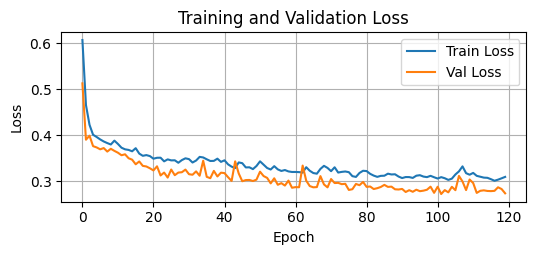

VALIDATION METRICS
ALS Denormalization using ../data/02_processed/ALS_norm_params_joint.json:
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.61m
 	RMSE: 	4.75m
 	Bias: 	-0.24m
----------------------------------------------
TEST METRICS
ALS Denormalization using ../data/02_processed/ALS_norm_params_joint.json:
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.87m
 	RMSE: 	5.11m
 	Bias: 	0.06m
----------------------------------------------


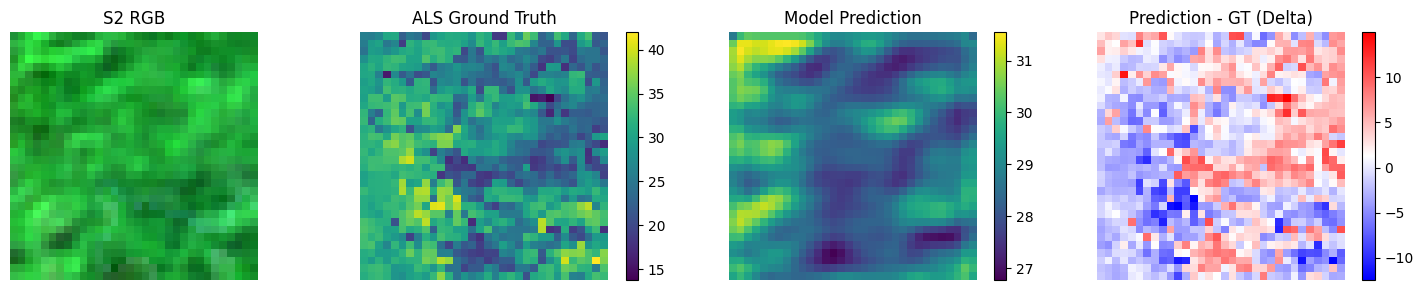

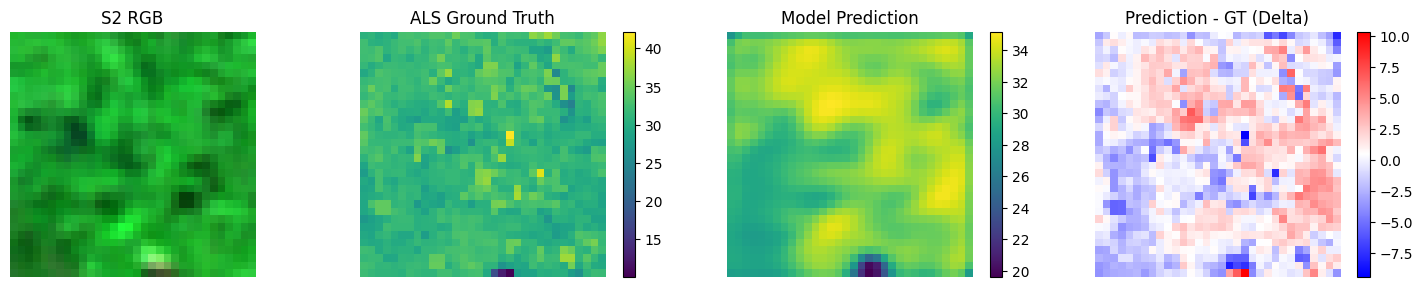

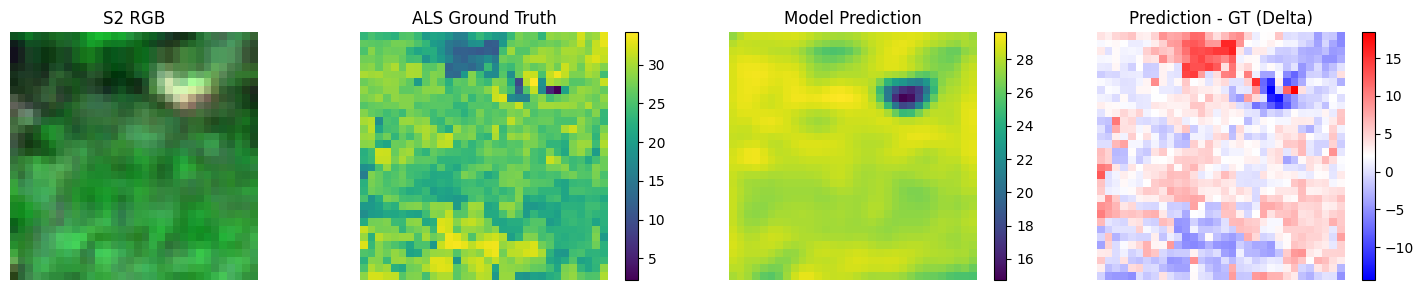

Configuration Parameters:
patch_size: 32
num_bands: 14
batch_size: 64
lr: 0.0012
weight_decay: 0.001
momentum: 0.9
epochs: 120
huber_delta: 0.8
device: mps
-------------------------------
Model Architecture:
UNet(
  (encoder1): Sequential(
    (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2

In [224]:
eval.plot_eval_report(train_losses, val_losses, model, val_loader,test_loader, json_path=ALS_NORM_PARAMS_JOINT, config=config)

## manual eval

In [184]:
print("VALIDATION METRICS")
predictions, targets = eval.denorm_model_json(model, val_loader, ALS_NORM_PARAMS_JOINT,config=config)
print("TEST METRICS")
pred_test, target_test = eval.denorm_model_json(model, test_loader, ALS_NORM_PARAMS_JOINT,config=config)


VALIDATION METRICS
ALS Denormalization using ../data/02_processed/ALS_norm_params_joint.json:
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.61m
 	RMSE: 	4.75m
 	Bias: 	-0.24m
----------------------------------------------
TEST METRICS
ALS Denormalization using ../data/02_processed/ALS_norm_params_joint.json:
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.87m
 	RMSE: 	5.11m
 	Bias: 	0.06m
----------------------------------------------


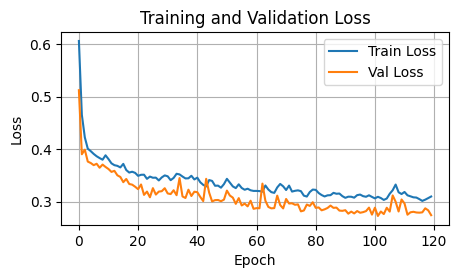

In [185]:
eval.plot_val_loss(train_losses, val_losses)

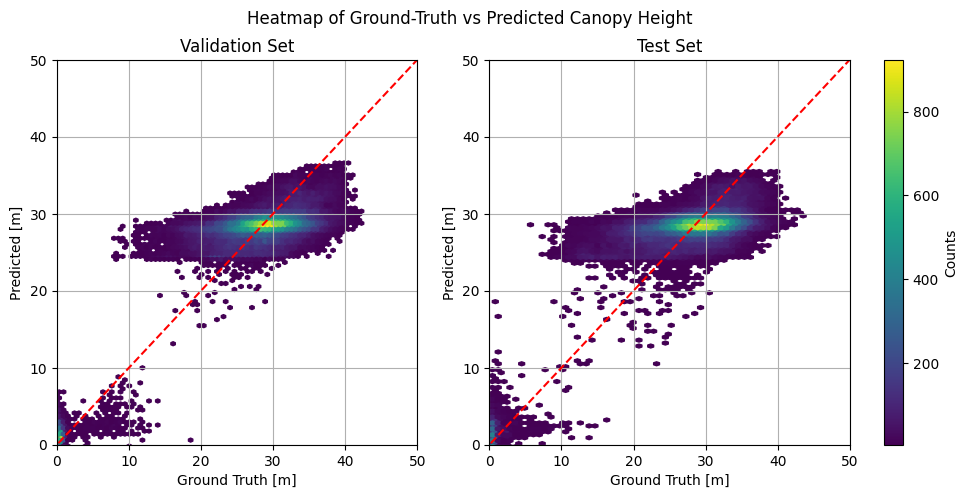

In [204]:
eval.plot_compact_heatmap_val_test(targets, predictions, target_test, pred_test)

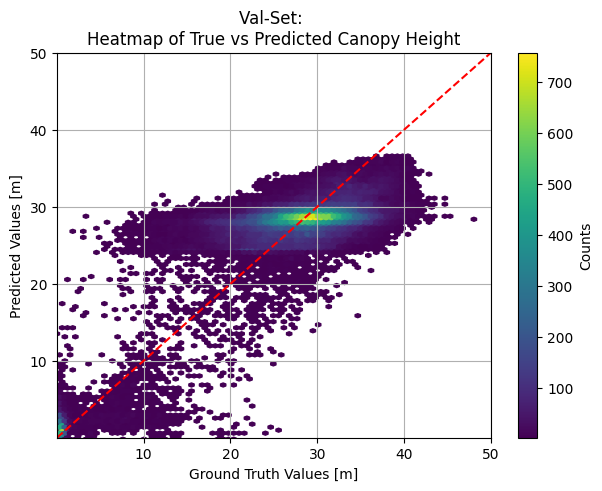

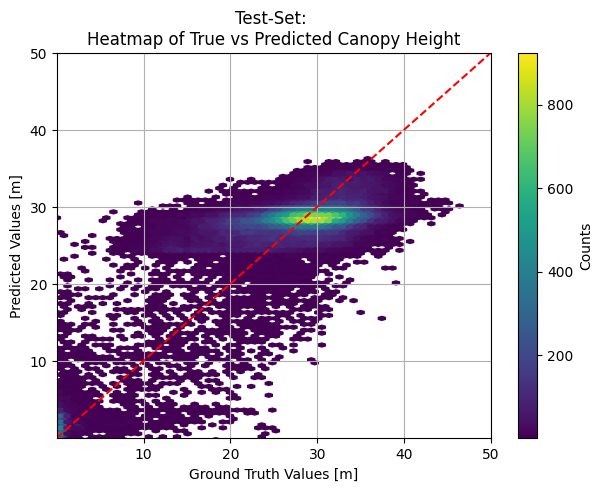

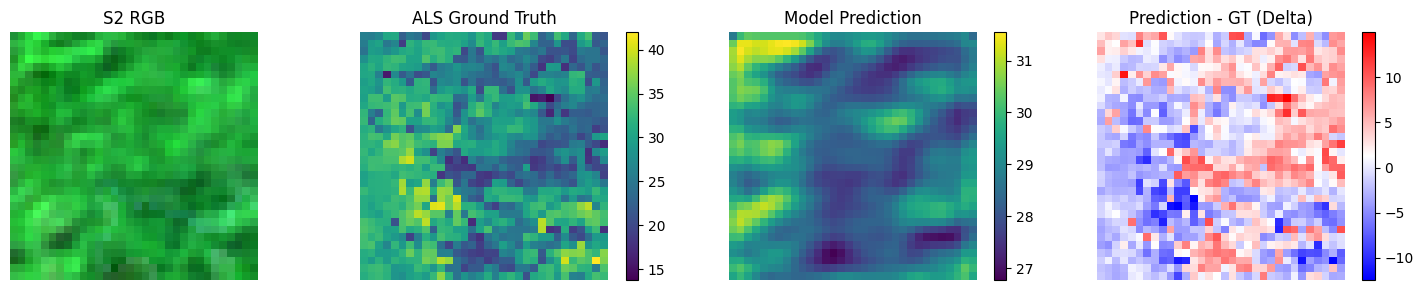

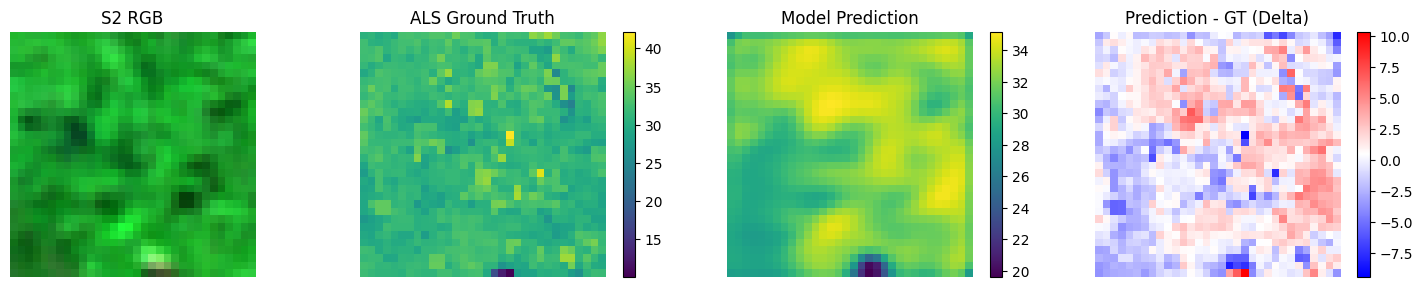

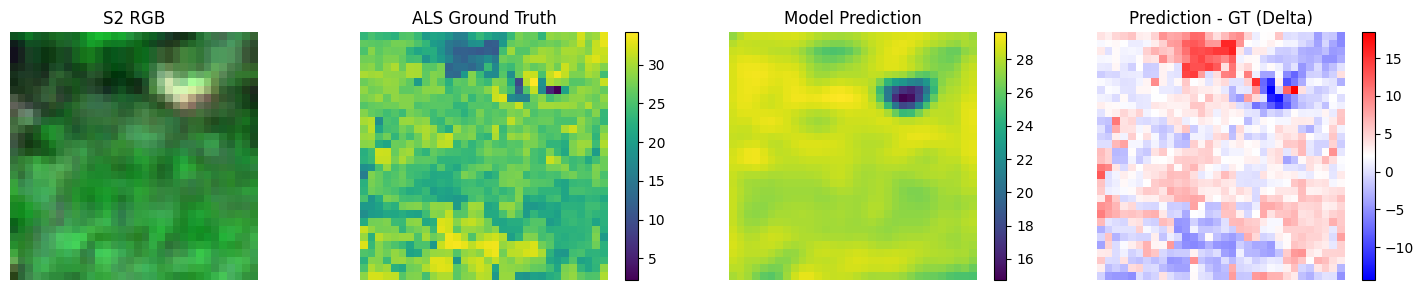

In [188]:
eval.plot_heatmap(targets, predictions, title="Val-Set: \nHeatmap of True vs Predicted Canopy Height")
eval.plot_heatmap(target_test, pred_test, title="Test-Set: \nHeatmap of True vs Predicted Canopy Height")
eval.plot_real_pred_delta(model, val_loader, num_samples=3, device=config['device'],json_path=ALS_NORM_PARAMS_JOINT)

Better normalization strategy for bias-compensation: 
- dont compute mean, std for each site 
- rather normnalize for greater area. 
--> Reason: Sites have different height distributions. 


In [187]:
if False:
    torch.save(model.state_dict(), "unet_canopy_model3.pth")